In [1]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d

# ======================
# 配置
# ======================
TARGET_N = 100
REVERSE_COORDS = True   # <<< 控制是否反转坐标及对应属性
# ======================


def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)


def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    # 提取曲线坐标
    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])
    resampled_coords = resample_array(coords, TARGET_N)

    # 读取并插值 point data
    pd = polydata.GetPointData()
    point_data = {}
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data

    # 额外提取 curvature / torsion / lab（若存在）
    for key in ["Curvature", "Torsion", "Lab"]:
        if key not in point_data and pd.HasArray(key):
            arr = numpy_support.vtk_to_numpy(pd.GetArray(key))
            point_data[key] = resample_array(arr, TARGET_N)

    # cell data（可选）
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    # === 若开启反转模式 ===
    if REVERSE_COORDS:
        resampled_coords = np.flip(resampled_coords, axis=0)
        for k, v in point_data.items():
            if isinstance(v, np.ndarray) and v.shape[0] == TARGET_N:
                point_data[k] = np.flip(v, axis=0)

    return point_data, cell_data, resampled_coords


def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                "point_data": point_data,
                "cell_data": cell_data,
                "coords": coords
            }
    return results


# === 设置路径并加载 ===
base_dir = r"D:\!BraVa_src\ica_results\siphon"
vtk_data_dict = batch_read_vtk_data(base_dir)

# 平移坐标使起点在原点
for name in vtk_data_dict:
    coords = vtk_data_dict[name]["coords"]
    vtk_data_dict[name]["coords"] = coords - coords[0]

print(f"✅ Loaded {len(vtk_data_dict)} curves; each resampled to {TARGET_N} points.")
print(f"✅ Coordinate reversed: {REVERSE_COORDS}")
print(f"✅ Example keys in point_data: {list(vtk_data_dict[list(vtk_data_dict.keys())[0]]['point_data'].keys())}")


✅ Loaded 77 curves; each resampled to 100 points.
✅ Coordinate reversed: True
✅ Example keys in point_data: ['MaximumInscribedSphereRadius', 'curvature', 'torsion', 'lab']


In [2]:
import pandas as pd
import os

# === 分类表路径 ===
category_csv = r"D:\!BraVa_src\ica_results\siphon\category\classified_centerlines_BestDrop.csv"

# 读取 CSV
df_category = pd.read_csv(category_csv)

# 将 β 列重命名为 beta
df_category = df_category.rename(columns={"β": "beta", "Filename": "filename"})

# 建立一个快速查找字典 {filename: row_dict}
category_dict = {
    row["filename"]: {
        "CR_B1": row["CR_B1"],
        "CR_B2": row["CR_B2"],
        "beta": row["beta"],
        "Type": row["Type"]
    }
    for _, row in df_category.iterrows()
}

# === 合并进 vtk_data_dict ===
for name in vtk_data_dict:
    # 去掉扩展名（假设键名形如 BG0001_L_siphon_lab.vtk）
    key = os.path.splitext(name)[0]
    if key in category_dict:
        vtk_data_dict[name]["category_info"] = category_dict[key]
    else:
        vtk_data_dict[name]["category_info"] = None  # 若分类表中没有，置空

print(f"✅ Merged category info for {sum(v is not None for v in category_dict.values())} entries.")


✅ Merged category info for 77 entries.


=== 长度统计摘要 (Summary) ===
count    77.000000
mean     25.371902
std       4.380154
min      17.732239
25%      22.463047
50%      25.044138
75%      27.554427
max      45.113591
Name: Length, dtype: float64

=== 各类型长度均值 (Mean Length by Type) ===
Type
C    23.927462
S    23.948078
U    25.950371
V    23.235187
Name: Length, dtype: float64


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\1162120986.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lengths, x="Type", y="Length", order=order, palette="Set2", ax=axes[1], width=0.6)


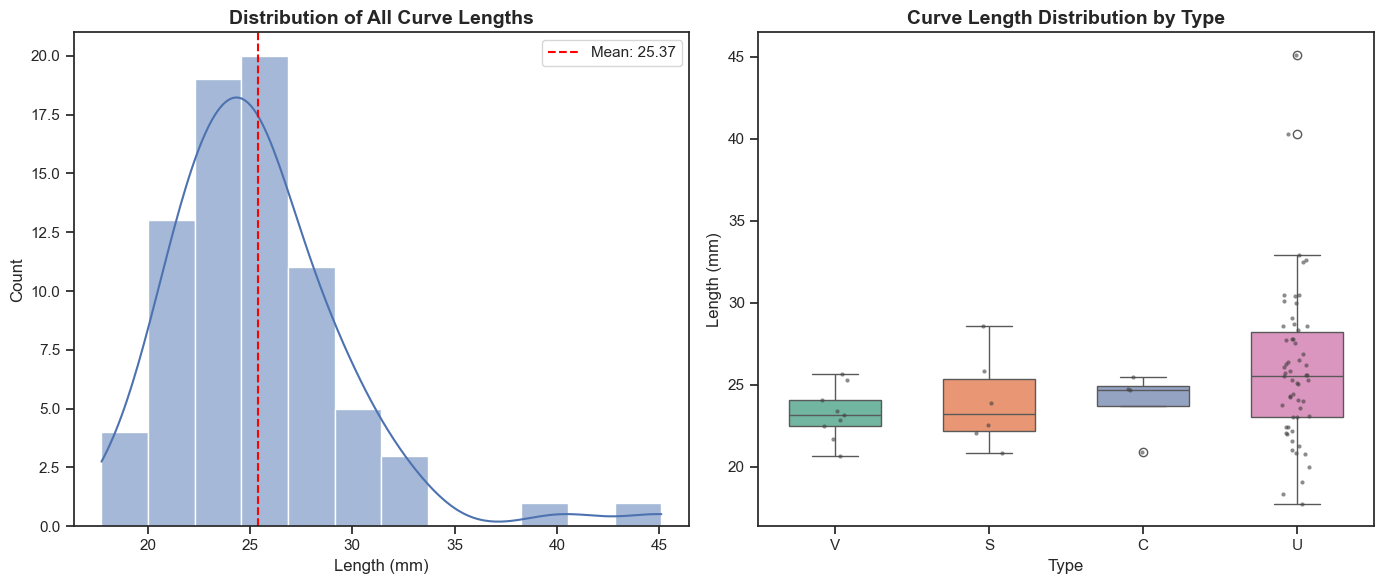

=== 最长的 10 条曲线 ===
Filename                       | Type       | Length (mm)
------------------------------------------------------------
BH0009_R_siphon_lab.vtk        | U          | 45.1136
BG0006_R_siphon_lab.vtk        | U          | 40.2882
BG0010_L_siphon_lab.vtk        | U          | 32.8865
BG0011_L_siphon_lab.vtk        | U          | 32.5948
BG0020_L_siphon_lab.vtk        | U          | 32.4551
BH0039_R_siphon_lab.vtk        | U          | 30.4719
BG0020_R_siphon_lab.vtk        | U          | 30.4417
BG0018_L_siphon_lab.vtk        | U          | 30.4108
BH0014_R_siphon_lab.vtk        | U          | 30.1080
BH0016_L_siphon_lab.vtk        | U          | 29.9663

文件名列表: ['BH0009_R_siphon_lab.vtk', 'BG0006_R_siphon_lab.vtk', 'BG0010_L_siphon_lab.vtk', 'BG0011_L_siphon_lab.vtk', 'BG0020_L_siphon_lab.vtk', 'BH0039_R_siphon_lab.vtk', 'BG0020_R_siphon_lab.vtk', 'BG0018_L_siphon_lab.vtk', 'BH0014_R_siphon_lab.vtk', 'BH0016_L_siphon_lab.vtk']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 定义计算长度的函数
# ==========================================
def calculate_curve_length(coords):
    """
    输入: (N, 3) 的坐标数组
    输出: 曲线总弧长
    """
    # 计算相邻点之间的向量差: (x2-x1, y2-y1, z2-z1)
    diffs = np.diff(coords, axis=0)
    # 计算每段的欧几里得距离
    segment_lengths = np.linalg.norm(diffs, axis=1)
    # 累加得到总长
    return np.sum(segment_lengths)

# ==========================================
# 2. 遍历数据并构建 DataFrame
# ==========================================
data_rows = []

for name, data in vtk_data_dict.items():
    coords = data["coords"]
    cat_info = data.get("category_info")
    
    # 计算长度
    length = calculate_curve_length(coords)
    
    # 获取分类 Type (若没有分类信息则标记为 'Unknown')
    ctype = "Unknown"
    if cat_info and isinstance(cat_info, dict) and "Type" in cat_info:
        ctype = cat_info["Type"]
    
    data_rows.append({
        "Filename": name,
        "Length": length,
        "Type": ctype
    })

# 转换为 DataFrame 方便分析
df_lengths = pd.DataFrame(data_rows)

# 打印简单的统计信息
print("=== 长度统计摘要 (Summary) ===")
print(df_lengths["Length"].describe())
print("\n=== 各类型长度均值 (Mean Length by Type) ===")
print(df_lengths.groupby("Type")["Length"].mean())

# ==========================================
# 3. 画图
# ==========================================
# 设置风格
sns.set(style="ticks")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- 图 1: 所有曲线长度分布 (Histogram + KDE) ---
sns.histplot(data=df_lengths, x="Length", kde=True, ax=axes[0], color="#4C72B0", edgecolor="w")
axes[0].set_title("Distribution of All Curve Lengths", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Length (mm)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
# 添加平均值竖线
mean_len = df_lengths["Length"].mean()
axes[0].axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f}')
axes[0].legend()

# --- 图 2: 各 Type 长度分布 (Boxplot) ---
# 计算排序顺序（按中位数从小到大）
order = df_lengths.groupby("Type")["Length"].median().sort_values().index

sns.boxplot(data=df_lengths, x="Type", y="Length", order=order, palette="Set2", ax=axes[1], width=0.6)
# 加上散点 (Strip plot) 以显示样本密度
sns.stripplot(data=df_lengths, x="Type", y="Length", order=order, color=".25", size=3, alpha=0.6, jitter=True, ax=axes[1])

axes[1].set_title("Curve Length Distribution by Type", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Type", fontsize=12)
axes[1].set_ylabel("Length (mm)", fontsize=12)

# 调整布局并保存
plt.tight_layout()
plt.savefig("curve_length_analysis.png", dpi=300)
plt.show()


# === 设置你需要输出的数量 ===
n = 10 

# 方法 1: 使用 nlargest (最简洁)
top_n = df_lengths.nlargest(n, 'Length')

# 方法 2: 先排序再取前 n 个 (经典方法)
# top_n = df_lengths.sort_values(by="Length", ascending=False).head(n)

print(f"=== 最长的 {n} 条曲线 ===")
print(f"{'Filename':<30} | {'Type':<10} | {'Length (mm)':<10}")
print("-" * 60)

for _, row in top_n.iterrows():
    print(f"{row['Filename']:<30} | {row['Type']:<10} | {row['Length']:.4f}")

# 如果你想把这些文件名存成一个列表供后续使用：
top_n_filenames = top_n["Filename"].tolist()
print(f"\n文件名列表: {top_n_filenames}")

In [4]:
# === GPA alignment in the quotient space (rotations + reparametrizations) ===
import os, json
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin
from geomstats.learning.frechet_mean import FrechetMean
from tqdm import tqdm
from datetime import datetime
import plotly.graph_objects as go
from plotly.colors import sample_colorscale

# ----------------------------
# Config
# ----------------------------
k_sampling_points = TARGET_N
max_iter = 10
tol = 1e-3
outdir = "aligned_results"
os.makedirs(outdir, exist_ok=True)

# ----------------------------
# Load your raw dict here
# ----------------------------
# 例如：
# vtk_data_dict = {
#     "A": {"coords": np.random.randn(240, 3)},
#     "B": {"coords": np.random.randn(240, 3)},
#     "C": {"coords": np.random.randn(240, 3)},
# }
# 实际使用时请加载你自己的字典

assert "vtk_data_dict" in globals(), "请先在上方定义或加载 vtk_data_dict"

# ----------------------------
# Construct manifold
# ----------------------------
M = DiscreteCurvesStartingAtOrigin(ambient_dim=3, k_sampling_points=k_sampling_points)
M.equip_with_group_action(("rotations", "reparametrizations"))
M.equip_with_quotient()

# ----------------------------
# Prepare curves
# ----------------------------
curves0_names = list(vtk_data_dict.keys())
curves0 = []
for name in curves0_names:
    P = gs.array(vtk_data_dict[name]["coords"])
    P_proj = M.projection(P)
    P_norm = M.normalize(P_proj)
    curves0.append(P_norm)

n_curves = len(curves0)
print(f"[Init] {n_curves} curves loaded; each has {k_sampling_points} points.")

# ----------------------------
# GPA iterations
# ----------------------------
template = curves0[0]
last_obj = np.inf
history = []

for it in tqdm(range(1, max_iter + 1), desc="GPA iterations", unit="iter"):
    aligned = []
    for C in tqdm(curves0, desc=f" Iter {it} align", leave=False):
        aligned.append(M.fiber_bundle.align(C, template))

    mean_est = FrechetMean(M)
    mean_est.fit(gs.array(aligned))
    new_template = mean_est.estimate_

    diff = gs.linalg.norm((new_template - template).reshape(-1))
    obj_vals = [M.metric.squared_dist(C, new_template) for C in aligned]
    obj = float(gs.mean(obj_vals))
    history.append((it, float(diff), obj))
    tqdm.write(f"[Iter {it:02d}] Δtemplate={diff:.4e}, mean_sq_dist={obj:.6f}")

    if (abs(float(last_obj) - obj) < tol) and (diff < tol):
        template = new_template
        break

    template = new_template
    last_obj = obj

aligned_final = [M.fiber_bundle.align(C, template) for C in curves0]
aligned_final_dict = {name: gs.array(C) for name, C in zip(curves0_names, aligned_final)}
mean_curve = gs.array(template)

print(f"[Done] {len(history)} iterations; final mean_sq_dist={history[-1][2]:.6f}")

# ----------------------------
# Save results
# ----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = os.path.join(outdir, f"aligned_siphon_{timestamp}.json")
save_dict = {
    "aligned_curves": {name: C.tolist() for name, C in aligned_final_dict.items()},
    "mean_curve": mean_curve.tolist(),
    "history": history,
}
with open(outfile, "w") as f:
    json.dump(save_dict, f)
print(f"[Saved] Alignment results -> {outfile}")

# ----------------------------
# Plotly visualization
# ----------------------------
colors = sample_colorscale("Turbo", np.linspace(0, 1, len(aligned_final_dict)))
fig = go.Figure()
for i, (name, C) in enumerate(aligned_final_dict.items()):
    fig.add_trace(go.Scatter3d(
        x=C[:, 0], y=C[:, 1], z=C[:, 2],
        mode="lines",
        line=dict(width=2, color=colors[i]),
        name=name,
        showlegend=(i == 0)
    ))

fig.add_trace(go.Scatter3d(
    x=mean_curve[:, 0], y=mean_curve[:, 1], z=mean_curve[:, 2],
    mode="lines",
    line=dict(width=6, color="black"),
    name="Mean"
))

fig.update_layout(
    height=600, width=700,
    title="Aligned curves (rotations + reparam)",
    margin=dict(l=0, r=0, t=40, b=0),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    )
)
fig.show()


[Init] 77 curves loaded; each has 100 points.


GPA iterations:  10%|█         | 1/10 [01:13<11:02, 73.56s/iter]

[Iter 01] Δtemplate=7.5244e-01, mean_sq_dist=0.103543


GPA iterations:  20%|██        | 2/10 [02:21<09:23, 70.46s/iter]

[Iter 02] Δtemplate=3.2647e-02, mean_sq_dist=0.100942


GPA iterations:  30%|███       | 3/10 [03:30<08:08, 69.74s/iter]

[Iter 03] Δtemplate=7.9841e-03, mean_sq_dist=0.100907


GPA iterations:  40%|████      | 4/10 [04:39<06:56, 69.41s/iter]

[Iter 04] Δtemplate=2.0008e-03, mean_sq_dist=0.100906


GPA iterations:  40%|████      | 4/10 [05:47<08:41, 86.87s/iter]


[Iter 05] Δtemplate=7.0780e-04, mean_sq_dist=0.100907
[Done] 5 iterations; final mean_sq_dist=0.100907
[Saved] Alignment results -> aligned_results\aligned_siphon_20251209_131120.json


Number of aligned curves: 77
Shape of one curve: (99, 3)
Aligned array shape: (77, 99, 3)
Aligned array shape: (77, 99, 3)
Mean curve shape: (99, 3)
[tPCA] Explained variance ratio (first 10 PCs): [0.62446094 0.18339835 0.08982619 0.05324479 0.01780283 0.01428117
 0.0065757  0.00390241 0.00265583 0.00144949]


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\425292243.py:63: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\425292243.py:69: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



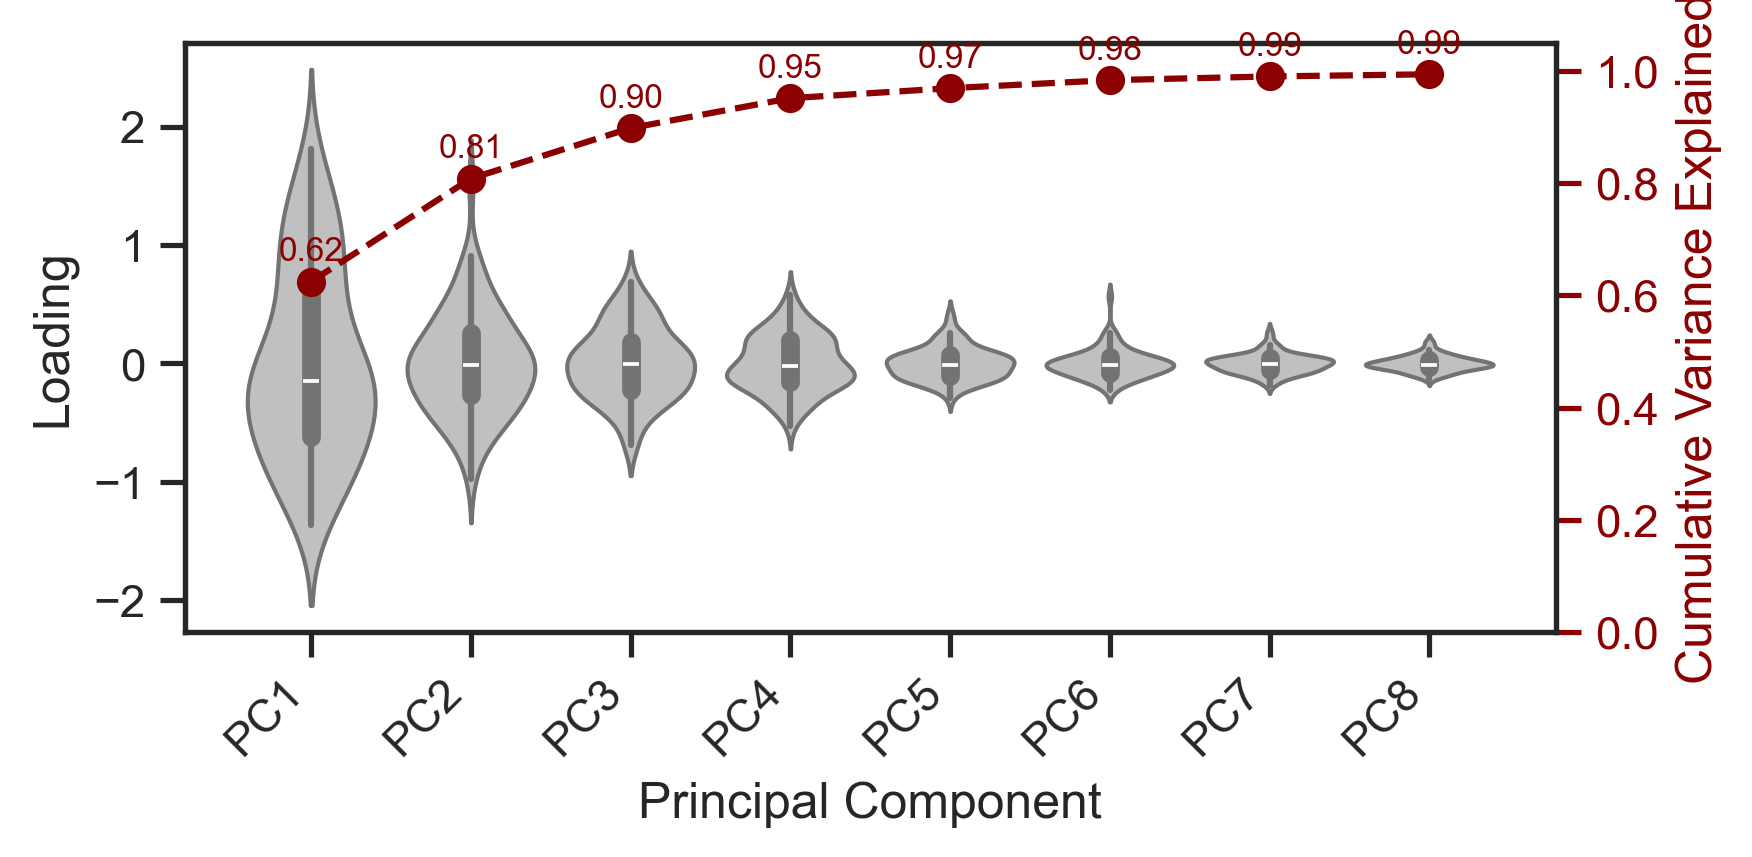


=== Explained Variance per PC ===
  PC  Explained_Variance_Ratio  Cumulative_Variance_Explained
 PC1                  0.624461                       0.624461
 PC2                  0.183398                       0.807859
 PC3                  0.089826                       0.897685
 PC4                  0.053245                       0.950930
 PC5                  0.017803                       0.968733
 PC6                  0.014281                       0.983014
 PC7                  0.006576                       0.989590
 PC8                  0.003902                       0.993492
 PC9                  0.002656                       0.996148
PC10                  0.001449                       0.997598

=== Loadings (first 5 rows) ===
      PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10
-0.554407 -0.015037  0.147751 -0.185461 -0.170080  0.063556 -0.154437  0.027489 -0.046995 -0.018456
-0.558318  0.052888  0.118786 -0.389345 -0.148075 

In [5]:
from geomstats.learning.pca import TangentPCA
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
import geomstats.backend as gs

# === tPCA on aligned curves ===
tPCA_N_COMPONENTS = 10

# Manifold
curves_r3_aligned = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)
curves_r3_aligned.equip_with_metric(SRVMetric)

# 从字典转成 list of arrays
aligned_curves = list(aligned_final_dict.values())
print("Number of aligned curves:", len(aligned_curves))
print("Shape of one curve:", aligned_curves[0].shape)

# 堆叠成 (n_curves, 240, 3)
aligned_curves_array = gs.stack(aligned_curves, axis=0)
print("Aligned array shape:", aligned_curves_array.shape)

print("Aligned array shape:", aligned_curves_array.shape)

# Fréchet mean as base point
mean_aligned = FrechetMean(curves_r3_aligned)
mean_aligned.fit(aligned_curves_array)
mean_curve_aligned = mean_aligned.estimate_
print("Mean curve shape:", mean_curve_aligned.shape)

# Tangent PCA
aligned_tpca = TangentPCA(curves_r3_aligned, n_components=tPCA_N_COMPONENTS)
aligned_tpca.fit(aligned_curves_array, base_point=mean_curve_aligned)
aligned_projected_data = aligned_tpca.transform(aligned_curves_array)

print(f"[tPCA] Explained variance ratio (first 10 PCs): {aligned_tpca.explained_variance_ratio_[:10]}")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 数据准备（前 K=8 个PC）----
explained_variance_ratio = aligned_tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
K = 8

df_long = (
    pd.DataFrame(aligned_projected_data[:, :K],
                 columns=[f"PC{i+1}" for i in range(K)])
      .melt(var_name="PC", value_name="Loading")
)

x_vals = np.arange(K)
labels = [f"PC{i+1}" for i in range(K)]

# ---- 绘图：小提琴 + 累计解释率 ----
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(
    data=df_long, x="PC", y="Loading",
    linewidth=1.0, scale="width", color="silver", ax=ax1
)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(x_vals, cumulative_ratio[:K],
         color='darkred', marker='o', linestyle='--',
         label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', colors='darkred')

# 数值标注
for x, y in zip(x_vals, cumulative_ratio[:K]):
    ax2.annotate(f"{y:.2f}", (x, y),
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=8, color='darkred')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


# === 导出每个PC的数值 ===

# 1. 每个PC的累计解释方差
cve_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained_Variance_Ratio": explained_variance_ratio,
    "Cumulative_Variance_Explained": cumulative_ratio
})

print("\n=== Explained Variance per PC ===")
print(cve_table.head(16).to_string(index=False))  # 打印前16个

# 2. 每个PC的loadings分布（即投影系数矩阵 aligned_projected_data）
loadings_table = pd.DataFrame(
    aligned_projected_data[:, :tPCA_N_COMPONENTS],
    columns=[f"PC{i+1}" for i in range(tPCA_N_COMPONENTS)]
)

print("\n=== Loadings (first 5 rows) ===")
print(loadings_table.head().to_string(index=False))

# 如果要保存为csv
# cve_table.to_csv("tpca_explained_variance.csv", index=False)
# loadings_table.to_csv("tpca_loadings.csv", index=False)



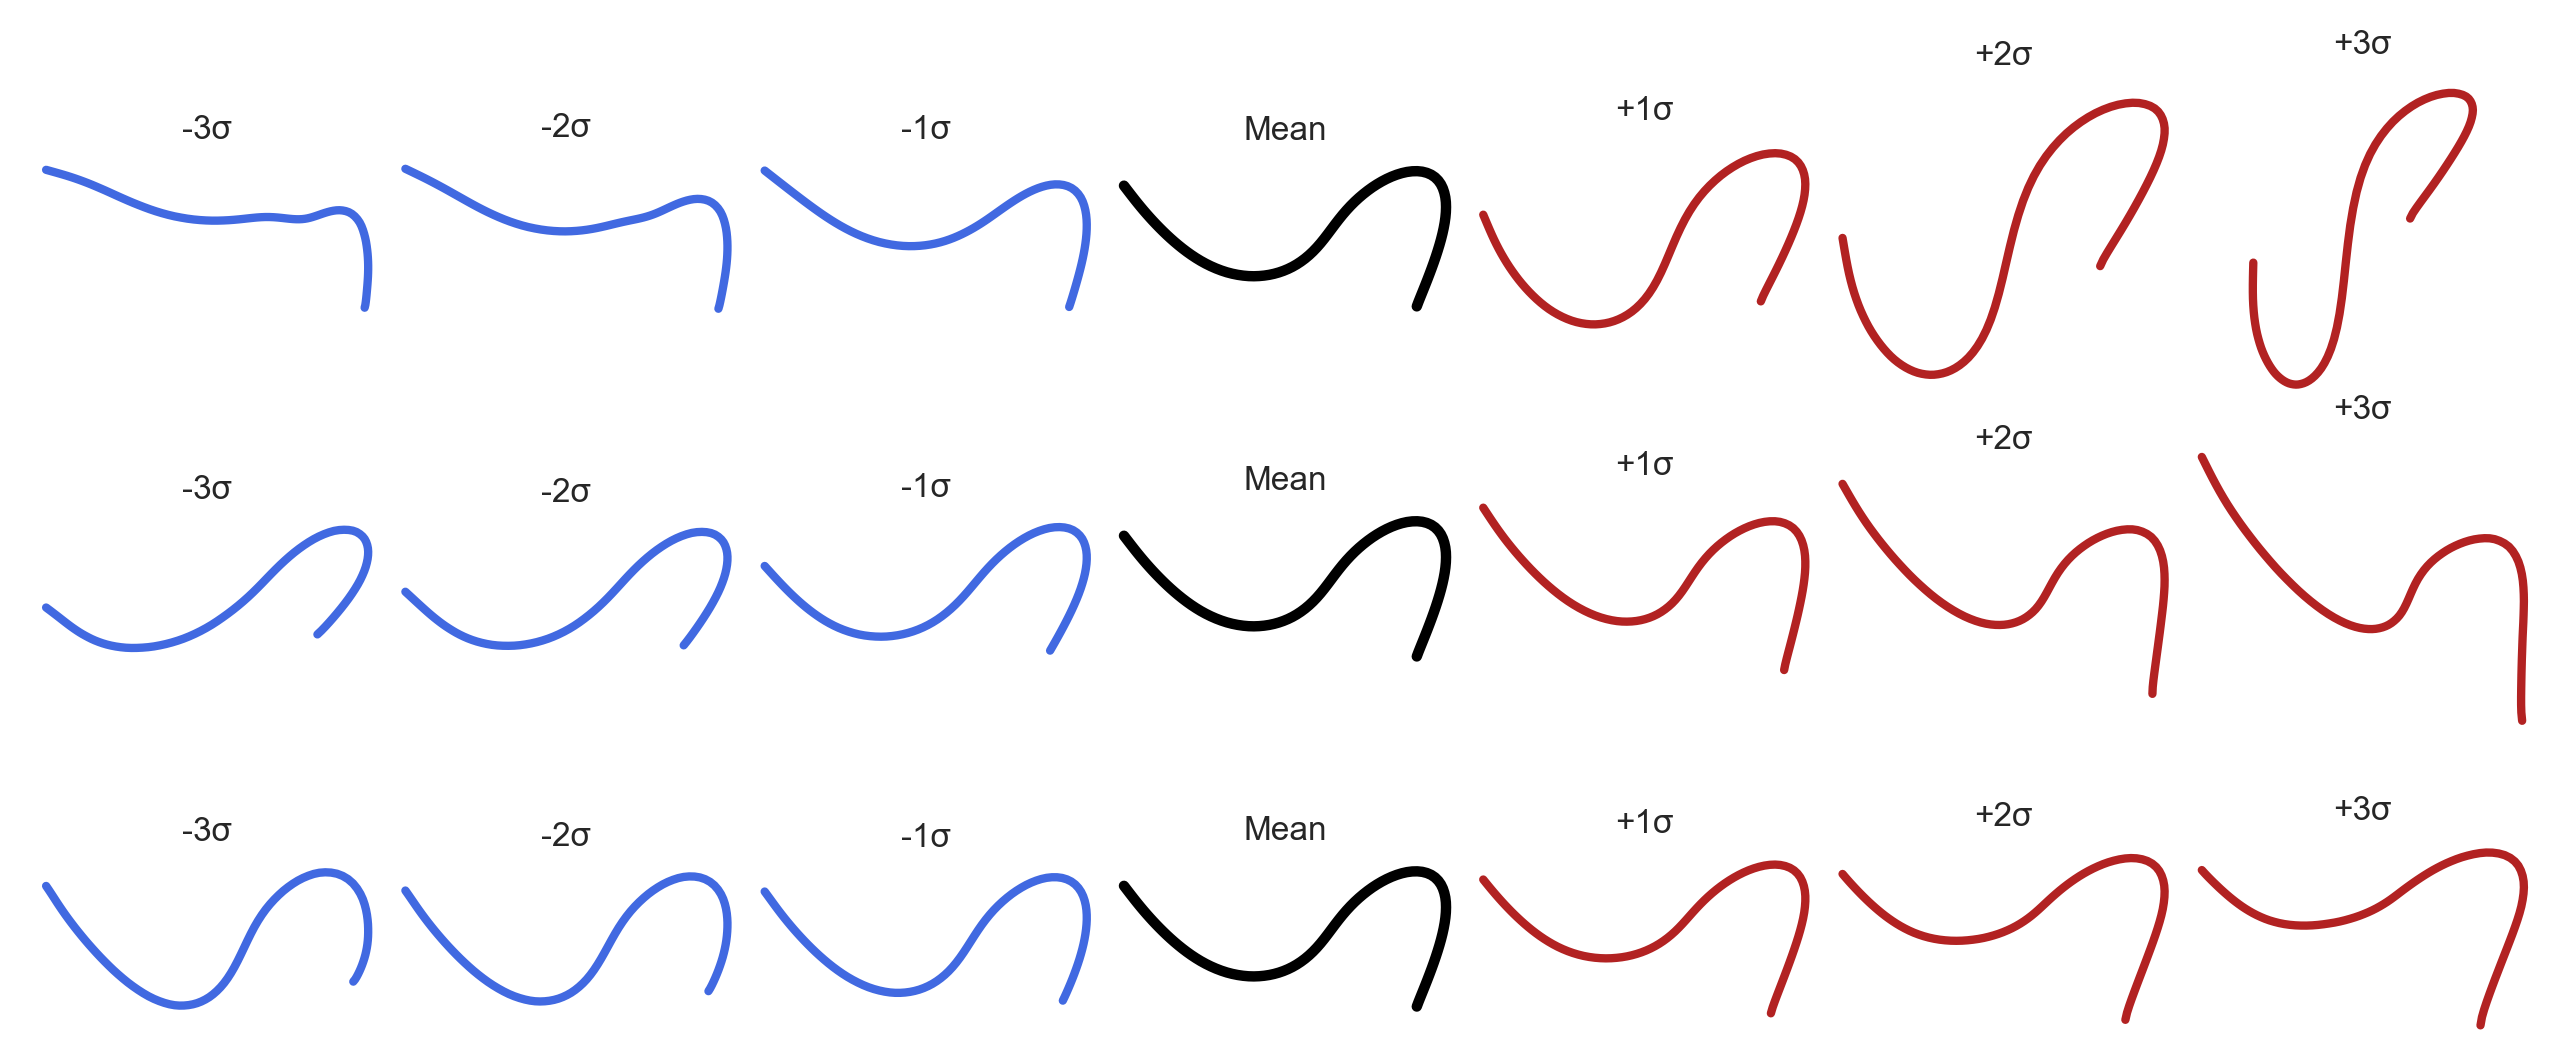

In [6]:
def rescale_curve_to_length(curve, target_length=75.0):
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    length = np.sum(seg_lengths)
    scale = target_length / length
    return curve * scale

# === 函数：数值求曲率 ===
def compute_curvature(curve):
    diffs = np.gradient(curve, axis=0)
    d2 = np.gradient(diffs, axis=0)
    cross = np.cross(diffs, d2)
    num = np.linalg.norm(cross, axis=1)
    denom = np.linalg.norm(diffs, axis=1) ** 3
    kappa = np.divide(num, denom, out=np.zeros_like(num), where=denom > 1e-6)
    return kappa

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [0, 1, 2]   # PC1, PC2, PC3
n_std = [1, 2, 3]            # ±1σ, ±2σ
n_cols = len(n_std)*2 + 1 # 每行的列数

fig, axes = plt.subplots(
    nrows=len(pcs_to_show),
    ncols=n_cols,
    figsize=(1.2*n_cols, 1.2*len(pcs_to_show)),  # 控制图像整体大小
    dpi=300
)

# 统一做一次 PCA 投影（用均值+所有变形曲线）
all_curves = [mean_curve_aligned]
for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for _, _, C in curves:
        all_curves.append(C)

all_points = np.vstack(all_curves)  # (N_total_points, 3)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 绘制 ===
for row, pc_idx in enumerate(pcs_to_show):
    ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

    # --- 生成该PC的所有曲线 ---
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    # 排序: -2σ, -1σ, Mean, +1σ, +2σ
    ordered = sorted(curves, key=lambda x: (x[0], x[1]))
    ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

    for col, (sign, s, C) in enumerate(ordered):
        ax = ax_row[col]
        proj = project2d(C)

        if s == 0:  # mean
            ax.plot(proj[:,0], proj[:,1], color="black", lw=2.5)
            ax.set_title("Mean", fontsize=8)
        else:  # variations
            color = "royalblue" if sign < 0 else "firebrick"
            ax.plot(proj[:,0], proj[:,1], color=color, lw=2.0)
            ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=8)

        # 去掉坐标和边框
        ax.axis("off")
        ax.set_aspect("equal")

    # 行标题
    ax_row[0].set_ylabel(f"PC{pc_idx+1}", fontsize=9, rotation=0, labelpad=20, weight="bold")

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\1754795325.py:125: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



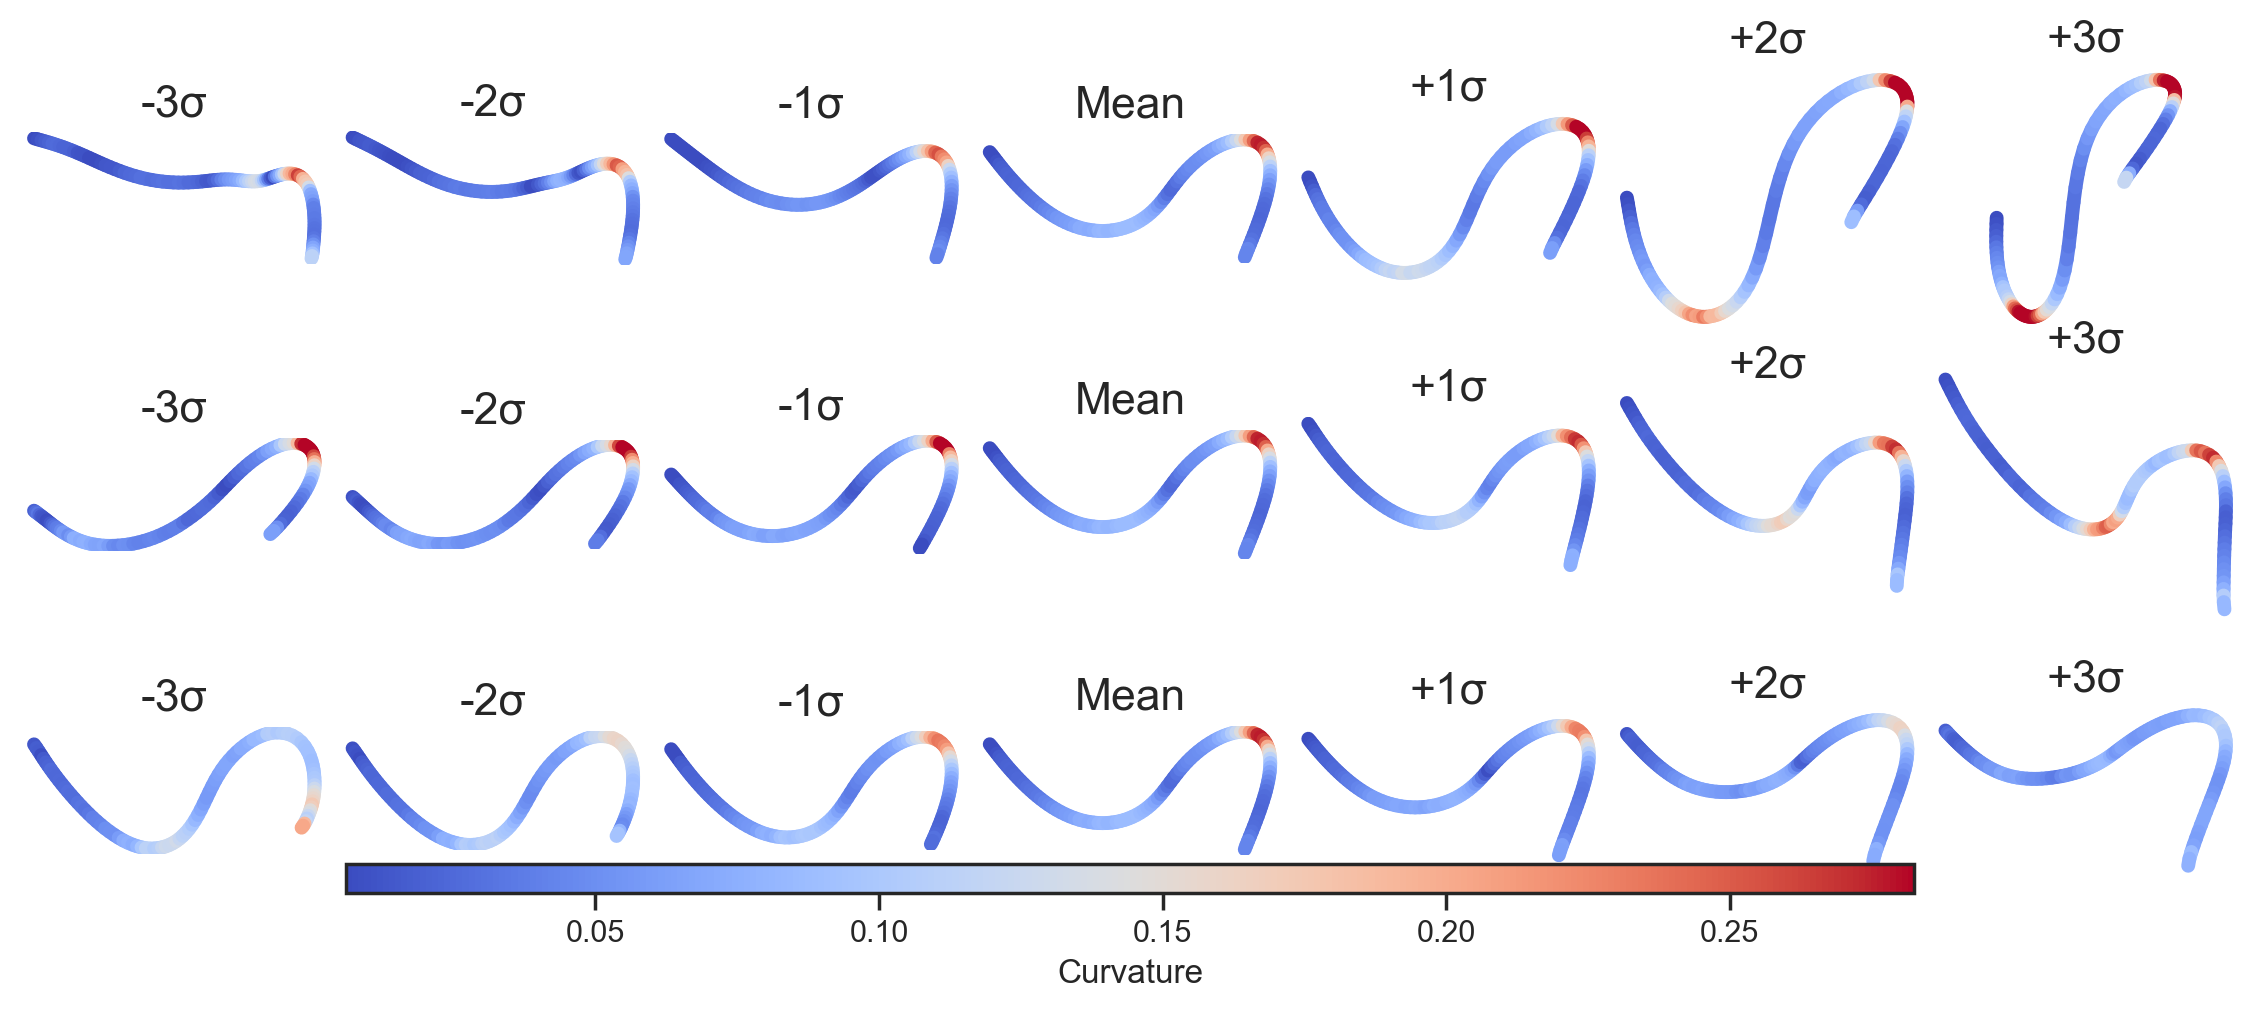

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import PCA

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [0, 1, 2]   # PC1, PC2, PC3
n_std = [1, 2, 3]         # ±1σ, ±2σ
n_cols = len(n_std)*2 + 1 # 每行的列数
cmap = plt.cm.coolwarm

# === 统一 PCA 投影 ===
all_curves = [mean_curve_aligned]
for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for _, _, C in curves:
        all_curves.append(C)

all_points = np.vstack(all_curves)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 计算所有曲率值，确定全局范围 ===
all_curv_vals = []
for C in all_curves:
    C_rescaled = rescale_curve_to_length(C, target_length=75.0)
    kappa = compute_curvature(C_rescaled)
    all_curv_vals.append(kappa)
all_curv_vals = np.concatenate(all_curv_vals)
vmin, vmax = np.min(all_curv_vals), np.max(all_curv_vals)

# 百分位裁剪
qmin, qmax = np.percentile(all_curv_vals, [2, 98])

# === 四种颜色映射方案 ===
norm_methods = {
    "Percentile (2–98%)": colors.Normalize(vmin=qmin, vmax=qmax),
}

# === 主绘图循环 ===
for norm_name, norm in norm_methods.items():
    fig, axes = plt.subplots(
        nrows=len(pcs_to_show),
        ncols=n_cols,
        figsize=(1.6*n_cols, 1.6*len(pcs_to_show)),
        dpi=200
    )

    for row, pc_idx in enumerate(pcs_to_show):
        ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

        # 生成该PC的所有曲线
        curves = reconstruct_along_pc(
            tpca=aligned_tpca,
            base_curve=mean_curve_aligned,
            pc_index=pc_idx,
            n_std=n_std,
            discrete_curves_space=curves_r3_aligned
        )

        ordered = sorted(curves, key=lambda x: (x[0], x[1]))
        ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

        for col, (sign, s, C) in enumerate(ordered):
            ax = ax_row[col]
            C_rescaled = rescale_curve_to_length(C, target_length=75.0)
            kappa = compute_curvature(C_rescaled)
            proj = project2d(C_rescaled)

            # 按曲率画彩色线
            for i in range(len(proj)-1):
                color = cmap(norm(kappa[i]))
                ax.plot(proj[i:i+2,0], proj[i:i+2,1], color=color, lw=5)

            # 标题
            if s == 0:
                ax.set_title("Mean", fontsize=16)
            else:
                ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=16)

            ax.axis("off")
            ax.set_aspect("equal")

        ax_row[0].set_ylabel(f"PC{pc_idx+1}", fontsize=9, rotation=0, labelpad=20, weight="bold")

    # 统一 colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # 在底部预留空间并添加横向 colorbar
    plt.subplots_adjust(bottom=0.10)                 # 给底部留出 18% 空间
    cax = fig.add_axes([0.15, 0.04, 0.70, 0.03])     # [left, bottom, width, height]
    fig.colorbar(sm, cax=cax, orientation='horizontal', label="Curvature")


    # fig.suptitle(norm_name, fontsize=12, weight="bold")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3, rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\3546200158.py:69: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



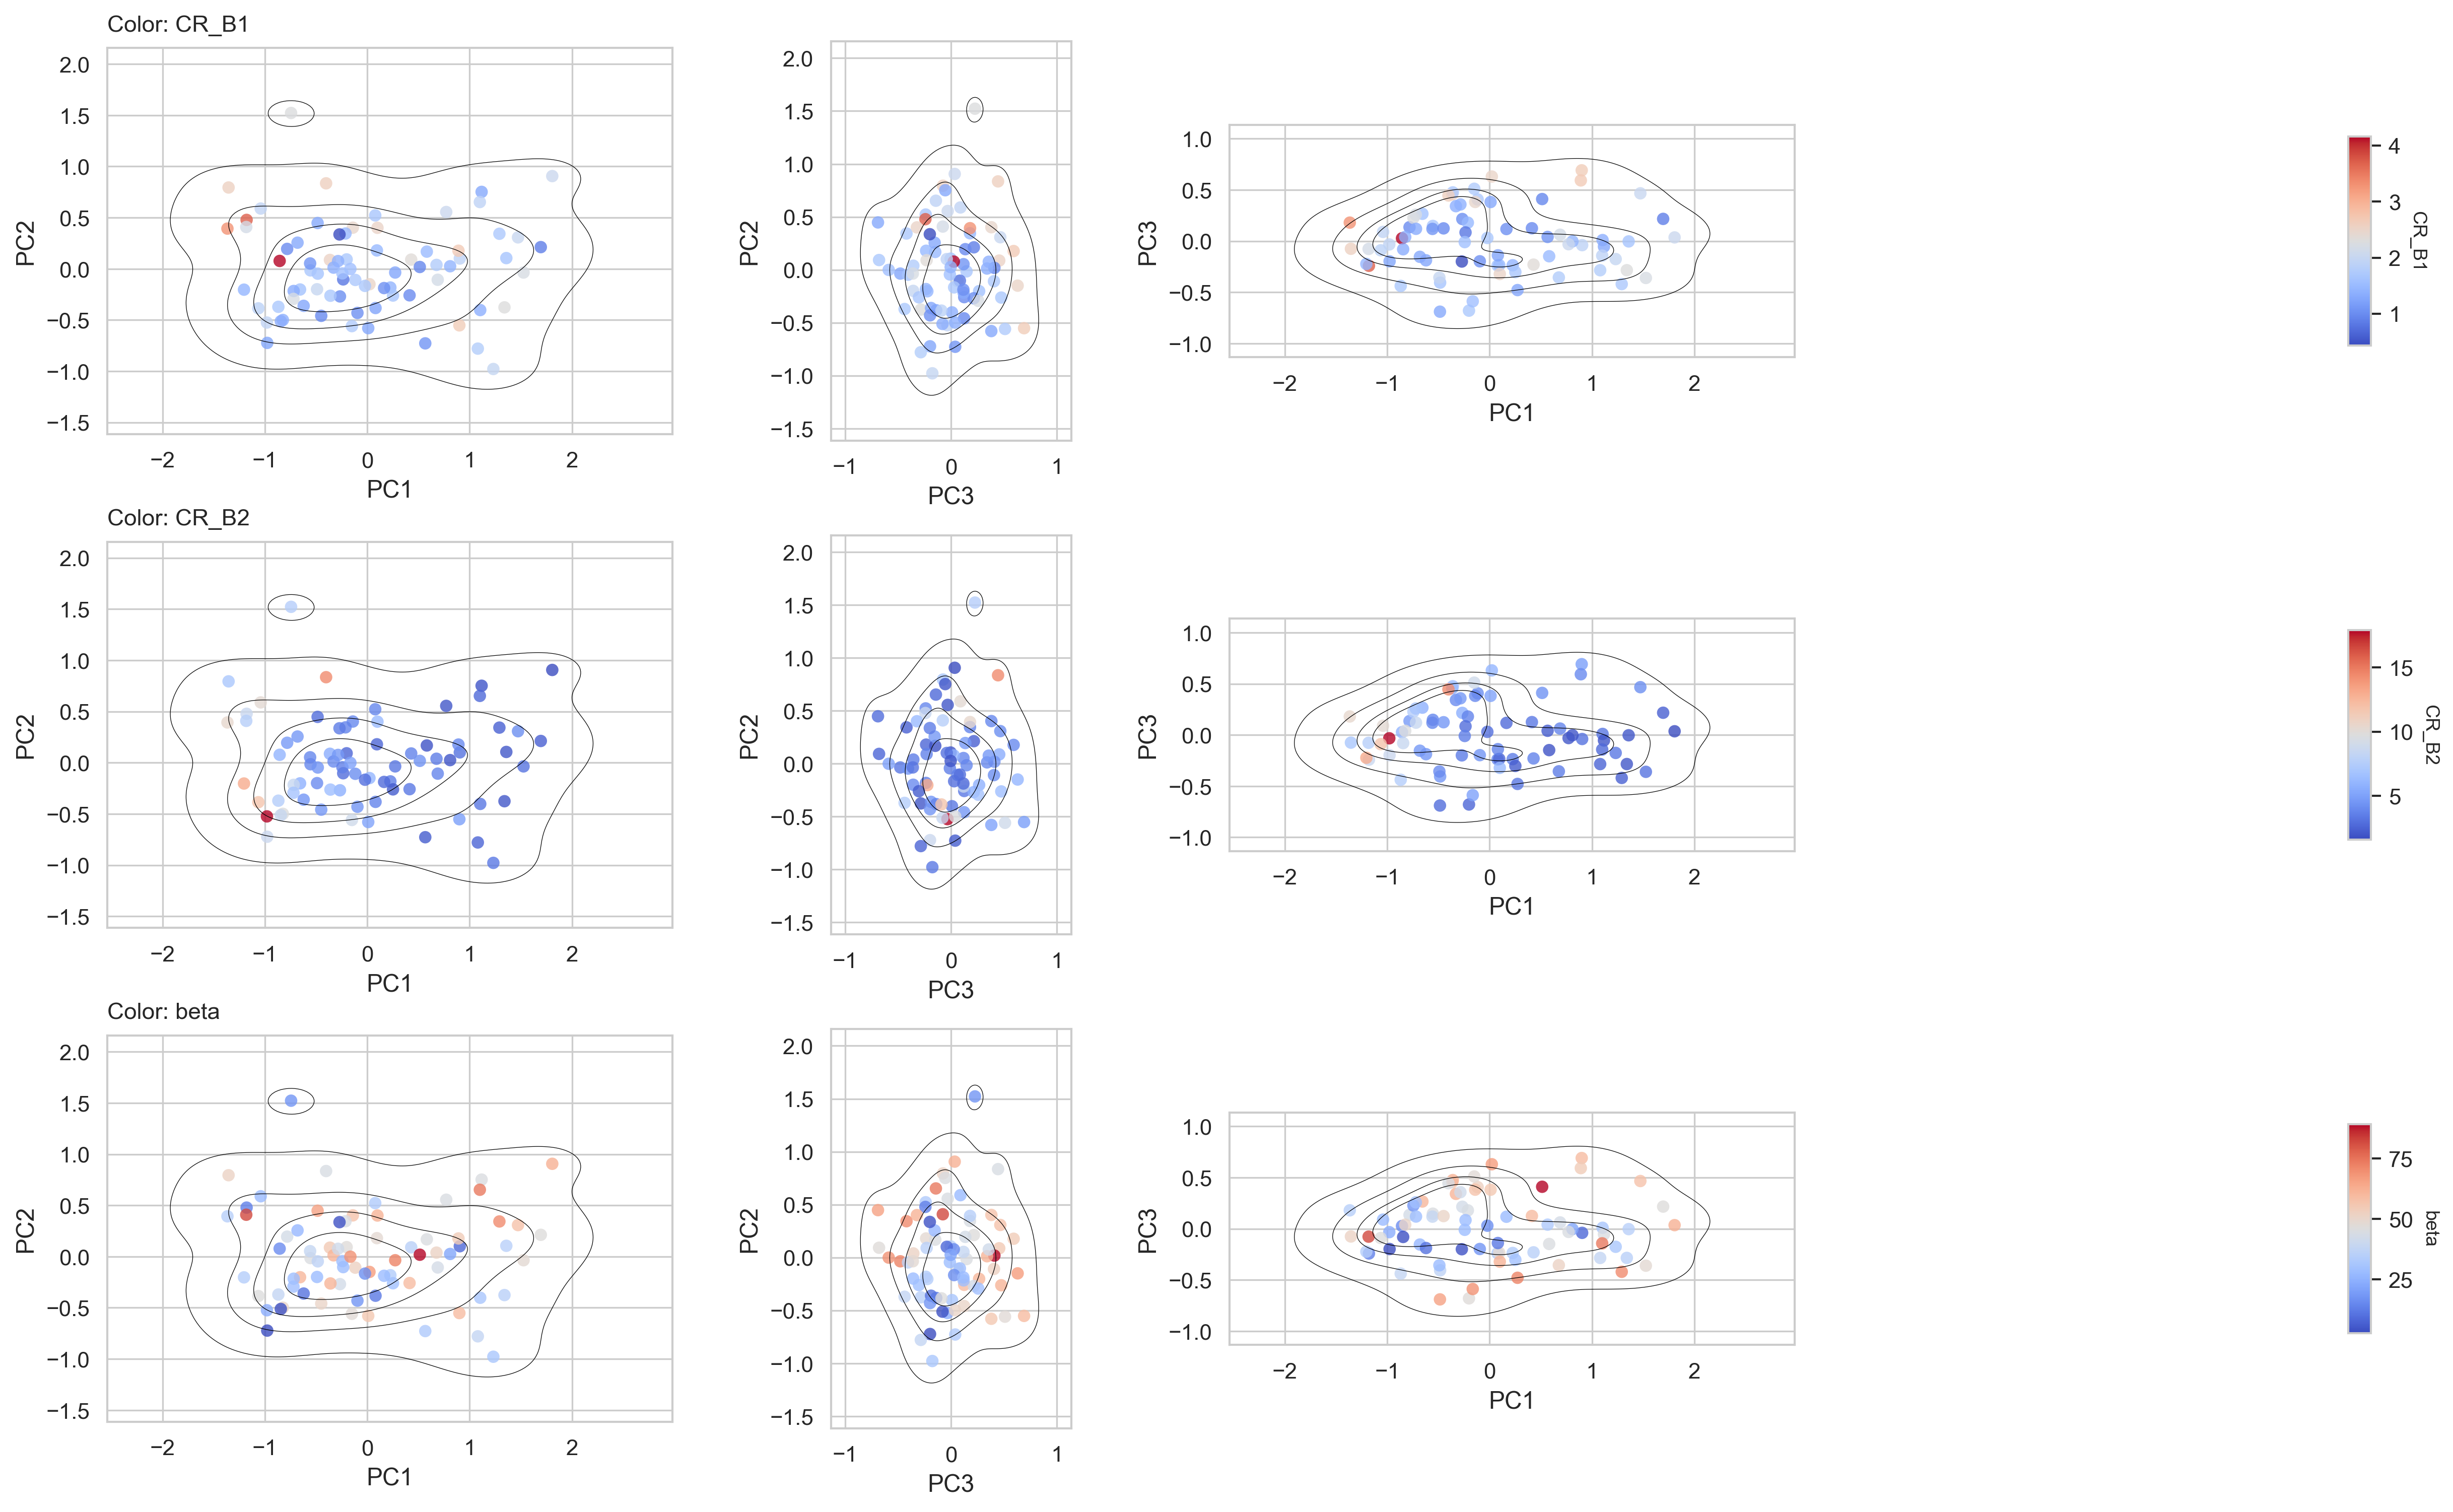

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

palette_name = 'coolwarm'

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# === Step 1. 组装 DataFrame ===
df_pca = pd.DataFrame(aligned_projected_data[:, :3], columns=["PC1", "PC2", "PC3"])
df_pca["filename"] = curves0_names

category_info = []
for name in curves0_names:
    info = vtk_data_dict[name].get("category_info", {})
    category_info.append({
        "CR_B1": info.get("CR_B1", np.nan),
        "CR_B2": info.get("CR_B2", np.nan),
        "beta":  info.get("beta",  np.nan)
    })

df_cat = pd.DataFrame(category_info)
df = pd.concat([df_pca, df_cat], axis=1)

# === Step 2. 绘图配置 ===
pairs = [("PC1", "PC2"), ("PC3", "PC2"), ("PC1", "PC3")]
color_vars = ["CR_B1", "CR_B2", "beta"]

fig, axes = plt.subplots(len(color_vars), len(pairs), figsize=(12, 10), dpi=300)

# === Step 3. 绘制散点 + KDE + colorbar ===
for row_idx, color_var in enumerate(color_vars):
    vmin = np.nanmin(df[color_var])
    vmax = np.nanmax(df[color_var])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for col_idx, (x, y) in enumerate(pairs):
        ax = axes[row_idx, col_idx]
        sns.scatterplot(
            x=x, y=y, data=df,
            hue=color_var, hue_norm=norm,
            palette=palette_name, s=35, alpha=0.8, edgecolor="none",
            ax=ax, legend=False
        )
        sns.kdeplot(x=x, y=y, data=df, levels=5, color="black", linewidths=0.3, ax=ax)
        ax.set_xlabel(x); ax.set_ylabel(y); ax.set_aspect("equal")

        if col_idx == 0:
            ax.set_title(f"Color: {color_var}", loc="left", fontsize=11, pad=8)

    # 在该行最后一个子图右侧嵌入 colorbar
    ax_for_cbar = axes[row_idx, -1]
    cax = inset_axes(
        ax_for_cbar,
        width="4%", height="90%",
        loc="center right",
        bbox_to_anchor=(1.02, 0., 1, 1),
        bbox_transform=ax_for_cbar.transAxes,
        borderpad=0
    )
    sm = mpl.cm.ScalarMappable(cmap=palette_name, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.set_ylabel(color_var, rotation=270, labelpad=12, fontsize=9)

plt.tight_layout()
plt.show()


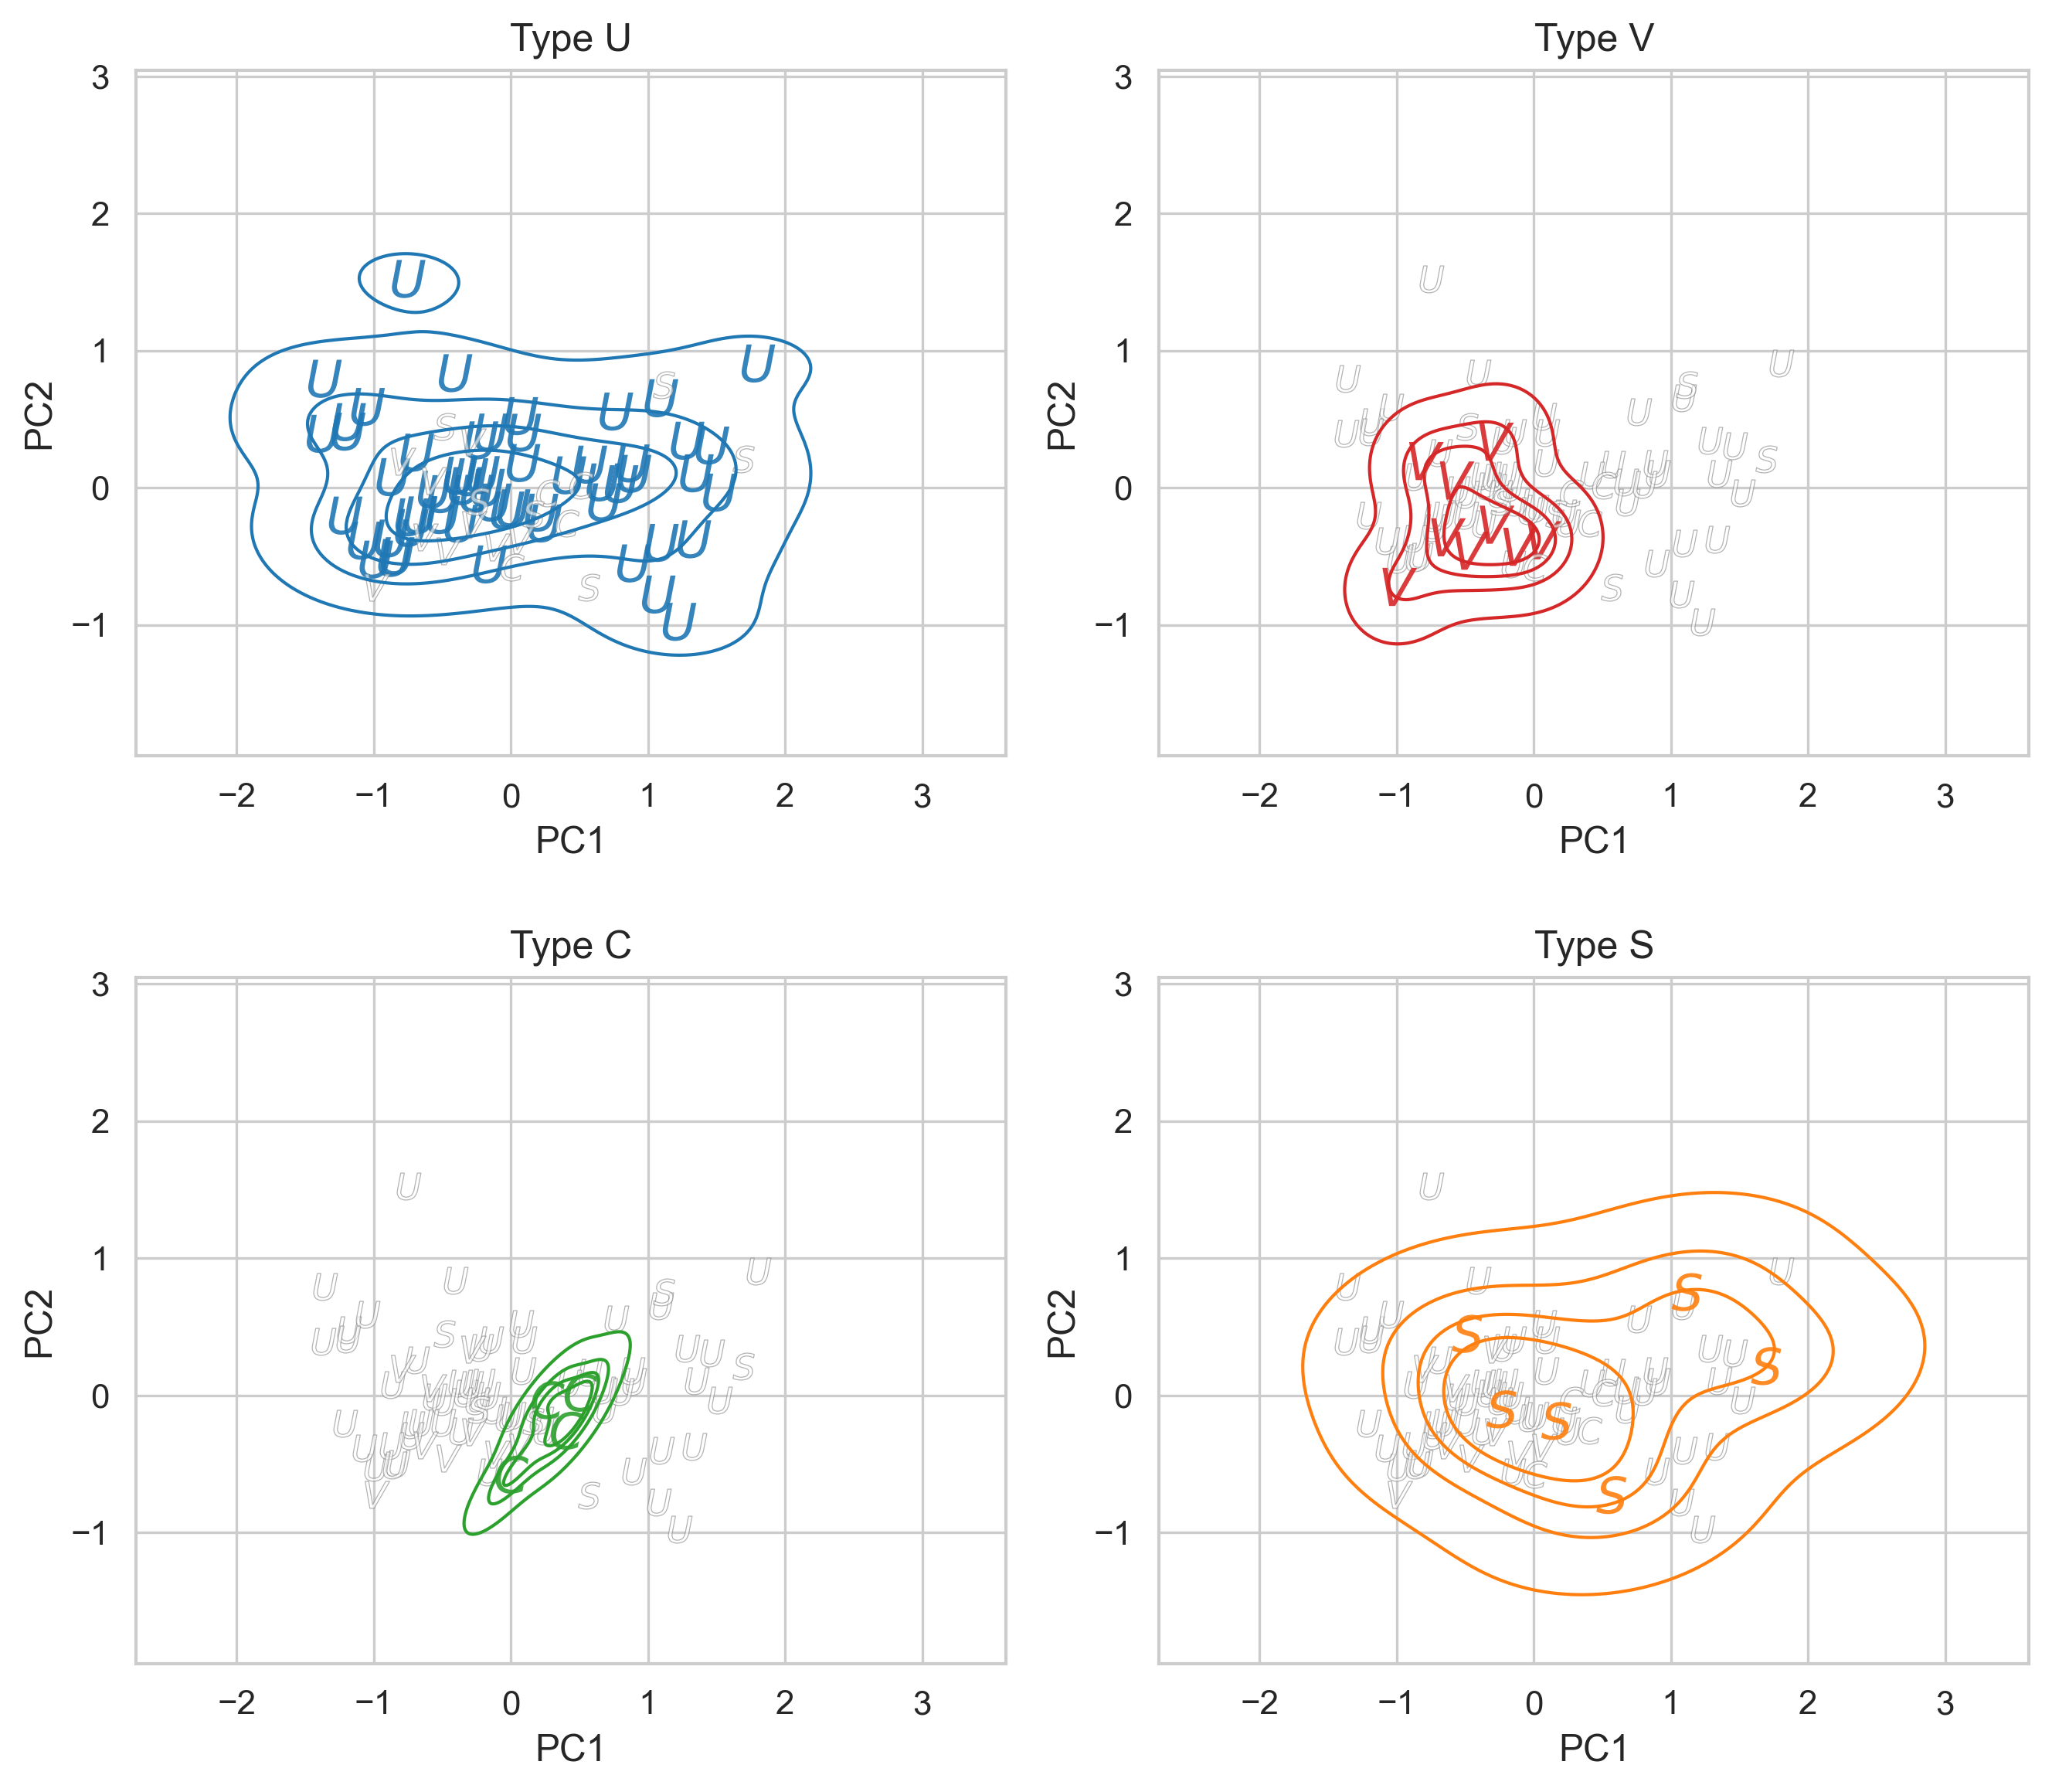

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === 构建 DataFrame ===
df_pca = pd.DataFrame(aligned_projected_data[:, :3], columns=["PC1", "PC2", "PC3"])
df_pca["filename"] = curves0_names
df_pca["Type"] = [
    vtk_data_dict[name].get("category_info", {}).get("Type", "Unknown")
    for name in curves0_names
]

# 颜色映射表
type_colors = {"U": "#1f77b4", "V": "#d62728", "C": "#2ca02c", "S": "#ff7f0e"}
types = ["U", "V", "C", "S"]

# === 绘图 ===
fig, axes = plt.subplots(2, 2, figsize=(9, 8), dpi=300)
axes = axes.ravel()

for i, t in enumerate(types):
    ax = axes[i]
    mask = df_pca["Type"] == t

    # 绘制所有类型（背景白）
    for other_t in types:
        other_mask = df_pca["Type"] == other_t
        color = "white" if other_t != t else type_colors[t]
        size = 140 if other_t == t else 70
        alpha = 0.9 if other_t == t else 0.6
        ax.scatter(
            df_pca.loc[other_mask, "PC1"],
            df_pca.loc[other_mask, "PC2"],
            marker=f"${other_t}$",
            s=size,
            c=color,
            edgecolors="gray" if other_t != t else "none",
            linewidths=0.3,
            alpha=alpha,
        )

    # 绘制目标类型密度等高线
    sns.kdeplot(
        x="PC1", y="PC2", data=df_pca.loc[mask],
        levels=5, color=type_colors[t],
        linewidths=1.0, ax=ax
    )

    ax.set_title(f"Type {t}", fontsize=12)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.set_xlim(df_pca["PC1"].min()*2, df_pca["PC1"].max()*2)
    ax.set_ylim(df_pca["PC2"].min()*2, df_pca["PC2"].max()*2)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import json

# 确保数据长度匹配
n_samples = len(curves0_names)
assert aligned_projected_data.shape[0] == n_samples, "PCA 行数与样本数量不匹配"

# 限制到前五个主成分
pc_labels = [f"PC{i+1}" for i in range(min(8, aligned_projected_data.shape[1]))]

# 构建导出字典
export_dict = {}
for i, name in enumerate(curves0_names):
    pcs = {pc_labels[j]: float(aligned_projected_data[i, j]) for j in range(len(pc_labels))}
    export_dict[name] = {
        "aligned_centerline": aligned_final_dict[name].tolist(), 
        "pcs": pcs
    }

import os
import json

# === 新的输出文件夹 ===
outdir = "exported_PCs_siphon"          # 你想要的新文件夹名
os.makedirs(outdir, exist_ok=True)  # 若不存在就自动创建

# === 文件路径 ===
out_path = os.path.join(outdir, "siphon_aligned_with_PCs.json")

# === 保存你的结果字典 ===
with open(out_path, "w") as f:
    json.dump(export_dict, f, indent=2)

print(f"✅ Saved to new folder: {out_path}")


✅ Saved to new folder: exported_PCs_siphon\siphon_aligned_with_PCs.json


In [11]:
import plotly.graph_objects as go

# === 1) 准备类型与颜色 ===
type_colors = {"U": "#1f77b4", "V": "#d62728", "C": "#2ca02c", "S": "#ff7f0e", "Unknown": "#999999"}

# 收集每条曲线的 Type
curve_types = {}
for name in aligned_final_dict.keys():
    info = vtk_data_dict.get(name, {}).get("category_info", {})  # 兼容没有category_info的情况
    t = info.get("Type", "Unknown")
    if t not in type_colors:
        t = "Unknown"
    curve_types[name] = t

# 实际出现过的类型（保持有序）
present_types = []
for t in ["U", "V", "C", "S", "Unknown"]:
    if any(tp == t for tp in curve_types.values()):
        present_types.append(t)

# === 2) 建图：每条曲线一条 trace + 额外加一条 Mean 曲线 ===
fig = go.Figure()
trace_type = []   # 记录每个trace的类别（不含均值）
trace_names = []  # 记录trace对应的曲线名（不含均值）

for name, t in curve_types.items():
    C = aligned_final_dict[name]
    fig.add_trace(go.Scatter3d(
        x=C[:, 0], y=C[:, 1], z=C[:, 2],
        mode="lines",
        line=dict(width=2, color=type_colors[t]),
        name=f"{t} — {name}",
        hoverinfo="name",
        showlegend=False
    ))
    trace_type.append(t)
    trace_names.append(name)

# 添加均值曲线（最后一个trace，按钮里始终保持可见）
mean_idx = len(fig.data)
fig.add_trace(go.Scatter3d(
    x=mean_curve[:, 0], y=mean_curve[:, 1], z=mean_curve[:, 2],
    mode="lines",
    line=dict(width=6, color="black"),
    name="Mean curve",
    showlegend=True
))

# === 3) 下拉菜单：构造不同按钮的可见性数组 ===
def vis_mask_for(filter_type):
    """
    返回一个长度==len(fig.data) 的布尔可见性列表。
    最后一条是 mean 曲线 -> 始终 True。
    其他曲线：当 filter_type == 'All' 时全 True；否则仅该类型 True。
    """
    n_curve_traces = len(fig.data) - 1
    if filter_type == "All":
        mask = [True]*n_curve_traces
    else:
        mask = [ (t == filter_type) for t in trace_type ]
    mask.append(True)  # mean curve
    return mask

buttons = []
# All
buttons.append(dict(
    label="All",
    method="update",
    args=[{"visible": vis_mask_for("All")}],
))
# 每个出现过的类型
for t in present_types:
    buttons.append(dict(
        label=t,
        method="update",
        args=[{"visible": vis_mask_for(t)}],
    ))

# === 4) 再加一个“图例颜色示意”的空trace（每类一个），便于读图 ===
# （这些只占图例，不在按钮里切换，不影响显示）
for t in present_types:
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode="lines",
        line=dict(width=4, color=type_colors[t]),
        name=f"Type {t}",
        showlegend=True
    ))
# 注意：这些图例trace默认可见；如果想让按钮也控制它们，可把它们纳入vis_mask_for逻辑

# === 5) 布局 ===
fig.update_layout(
    title="Aligned Curves by Type — interactive filter",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    ),
    legend=dict(
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=0.5
    ),
    height=720, width=980,
    updatemenus=[dict(
        type="dropdown",
        x=1.02, y=1.0, xanchor="left", yanchor="top",
        buttons=buttons,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="gray", borderwidth=0.5,
        showactive=True
    )]
)

fig.show()
# 假设你已经有 fig 对象
fig.write_html("aligned_by_type.html", include_plotlyjs=True, auto_open=True)

In [12]:
import numpy as np
import os
import vtk
from vtk.util import numpy_support

# ==========================================
# 1. 工具函数 (直接复用你的逻辑)
# ==========================================

def rescale_curve_to_length(curve, target_length=75.0):
    """ 将曲线缩放到指定物理长度 """
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    length = np.sum(seg_lengths)
    if length < 1e-6: return curve # 防止除以0
    scale = target_length / length
    return curve * scale

def save_vtk_polydata(coords, filepath):
    """ 保存为 VTK 文件 """
    points = vtk.vtkPoints()
    points.SetData(numpy_support.numpy_to_vtk(coords, deep=True))
    lines = vtk.vtkCellArray()
    lines.InsertNextCell(len(coords))
    for i in range(len(coords)):
        lines.InsertCellPoint(i)
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(points)
    polydata.SetLines(lines)
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filepath)
    writer.SetInputData(polydata)
    writer.Write()

# ==========================================
# 2. 核心生成逻辑 (仿照 reconstruct_along_pc)
# ==========================================

def generate_synthetic_shapes_by_type(
    target_type, 
    n_samples, 
    tpca, 
    base_curve, 
    metric_space, 
    projected_data, 
    names_list, 
    length_df,
    output_dir="synthetic_results"
):
    print(f"\n>>> Processing Type: {target_type}")
    os.makedirs(output_dir, exist_ok=True)

    # --- A. 准备组件 (Components) ---
    # 模仿 reconstruct_along_pc: 将扁平的 components 重塑为 (n_comps, n_points, 3)
    n_points = base_curve.shape[0]
    n_components = tpca.n_components_
    
    # 这里的 shape 应该是 (10, 100, 3)
    principal_components = tpca.components_.reshape((n_components, n_points, 3))

    # --- B. 获取该 Type 的分布统计 (Statistics) ---
    # 1. 找到索引
    indices = []
    for i, name in enumerate(names_list):
        # 注意：这里需要依赖外部的 vtk_data_dict，或者假设 names_list 和 projected_data 是一一对应的
        info = vtk_data_dict[name].get("category_info", {})
        if info and info.get("Type") == target_type:
            indices.append(i)
    
    if not indices:
        print(f"Warning: No samples found for Type {target_type}")
        return

    # 2. 提取系数并计算均值/协方差
    # 只取前 n_components 个系数 (通常就是 projected_data 的列数)
    type_scores = projected_data[indices, :n_components]
    
    mu_vec = np.mean(type_scores, axis=0)
    cov_mat = np.cov(type_scores, rowvar=False)

    # 防止奇异矩阵 (如果样本很少)
    if len(indices) <= n_components:
        cov_mat += np.eye(n_components) * 1e-5

    # --- C. 采样 (Sampling) ---
    # 生成 n_samples 个新的系数向量，每个向量长度为 n_components
    synthetic_scores = np.random.multivariate_normal(mu_vec, cov_mat, n_samples)

    # --- D. 获取目标物理长度 ---
    # 从 dataframe 中查平均长度
    avg_len = length_df[length_df["Type"] == target_type]["Length"].mean()
    print(f"  - Target Length: {avg_len:.2f} mm")
    print(f"  - Generating {n_samples} samples...")

    # --- E. 重建循环 (Reconstruction Loop) ---
    for i in range(n_samples):
        scores = synthetic_scores[i] # 一个 (10,) 的向量
        
        # 1. 构建切向量 (Manual Inverse Transform)
        # Tangent_Vec = sum( score_j * Component_j )
        # 利用 broadcasting: (10, 1, 1) * (10, 100, 3) -> sum axis 0 -> (100, 3)
        tangent_vec = np.sum(
            scores[:, np.newaxis, np.newaxis] * principal_components, 
            axis=0
        )
        
        # 2. 指数映射 (Exponential Map)
        # 将切向量映射回弯曲空间
        curve_recon = metric_space.metric.exp(
            tangent_vec=tangent_vec,
            base_point=base_curve
        )
        
        # 3. 恢复尺度 (Rescaling)
        curve_final = rescale_curve_to_length(curve_recon, target_length=avg_len)
        
        # 4. 保存
        fname = f"Gen_{target_type}_{i+1:02d}.vtk"
        save_vtk_polydata(curve_final, os.path.join(output_dir, fname))

    print(f"  - Done. Saved to {output_dir}")

# ==========================================
# 3. 执行
# ==========================================

target_types = ["V", "C"]  # 你想要生成的类型
num_gen = 10               # 生成数量

for t in target_types:
    generate_synthetic_shapes_by_type(
        target_type=t,
        n_samples=num_gen,
        tpca=aligned_tpca,                 # 你的 tPCA 对象
        base_curve=mean_curve_aligned,     # 你的平均形状
        metric_space=curves_r3_aligned,    # 你的流形空间定义
        projected_data=aligned_projected_data, # 所有数据的 PC 系数
        names_list=curves0_names,          # 文件名列表
        length_df=df_lengths               # 长度统计表
    )


>>> Processing Type: V
  - Target Length: 23.24 mm
  - Generating 10 samples...
  - Done. Saved to synthetic_results

>>> Processing Type: C
  - Target Length: 23.93 mm
  - Generating 10 samples...
  - Done. Saved to synthetic_results


In [13]:
# Carlos MASTER THESIS RESULTS

case_name_U = ['BG0011_L_siphon_lab.vtk','BG0018_L_siphon_lab.vtk']
case_name_V = ['BH0017_R_siphon_lab.vtk','BH0031_L_siphon_lab.vtk']
case_name_C = ['BH0006_L_siphon_lab.vtk']#,'BH0003_R_siphon_lab.vtk']

for case_name in case_name_U + case_name_V + case_name_C:
    # for case_name in case_name_list:
    print (case_name)
    print (vtk_data_dict[case_name]['category_info'])
    print (export_dict[case_name]['pcs'])

BG0011_L_siphon_lab.vtk
{'CR_B1': 2.0637, 'CR_B2': 1.6201, 'beta': 61.96, 'Type': 'U'}
{'PC1': 1.806322535298165, 'PC2': 0.9058326895359605, 'PC3': 0.03574733405838222, 'PC4': 0.23072851040006148, 'PC5': -0.1375568864380563, 'PC6': -0.11697392355038289, 'PC7': 0.027746764157464493, 'PC8': -0.012792286311125167}
BG0018_L_siphon_lab.vtk
{'CR_B1': 1.6568, 'CR_B2': 2.058, 'beta': 35.25, 'Type': 'U'}
{'PC1': 1.3577005229577084, 'PC2': 0.10506074292706652, 'PC3': -0.0031834162478898698, 'PC4': 0.03313350939761132, 'PC5': 0.017785726150960024, 'PC6': 0.08774192242895675, 'PC7': -0.18329354633723496, 'PC8': -0.009384658597827028}
BH0017_R_siphon_lab.vtk
{'CR_B1': 2.2204, 'CR_B2': 6.8383, 'beta': 29.18, 'Type': 'U'}
{'PC1': -0.7208339185337385, 'PC2': -0.29380688981216346, 'PC3': 0.25812817567825835, 'PC4': 0.24059701459402436, 'PC5': -0.13596678517292726, 'PC6': 0.04868301219396286, 'PC7': 0.030139523303835, 'PC8': 0.049404138009583945}
BH0031_L_siphon_lab.vtk
{'CR_B1': 1.3385, 'CR_B2': 8.5418

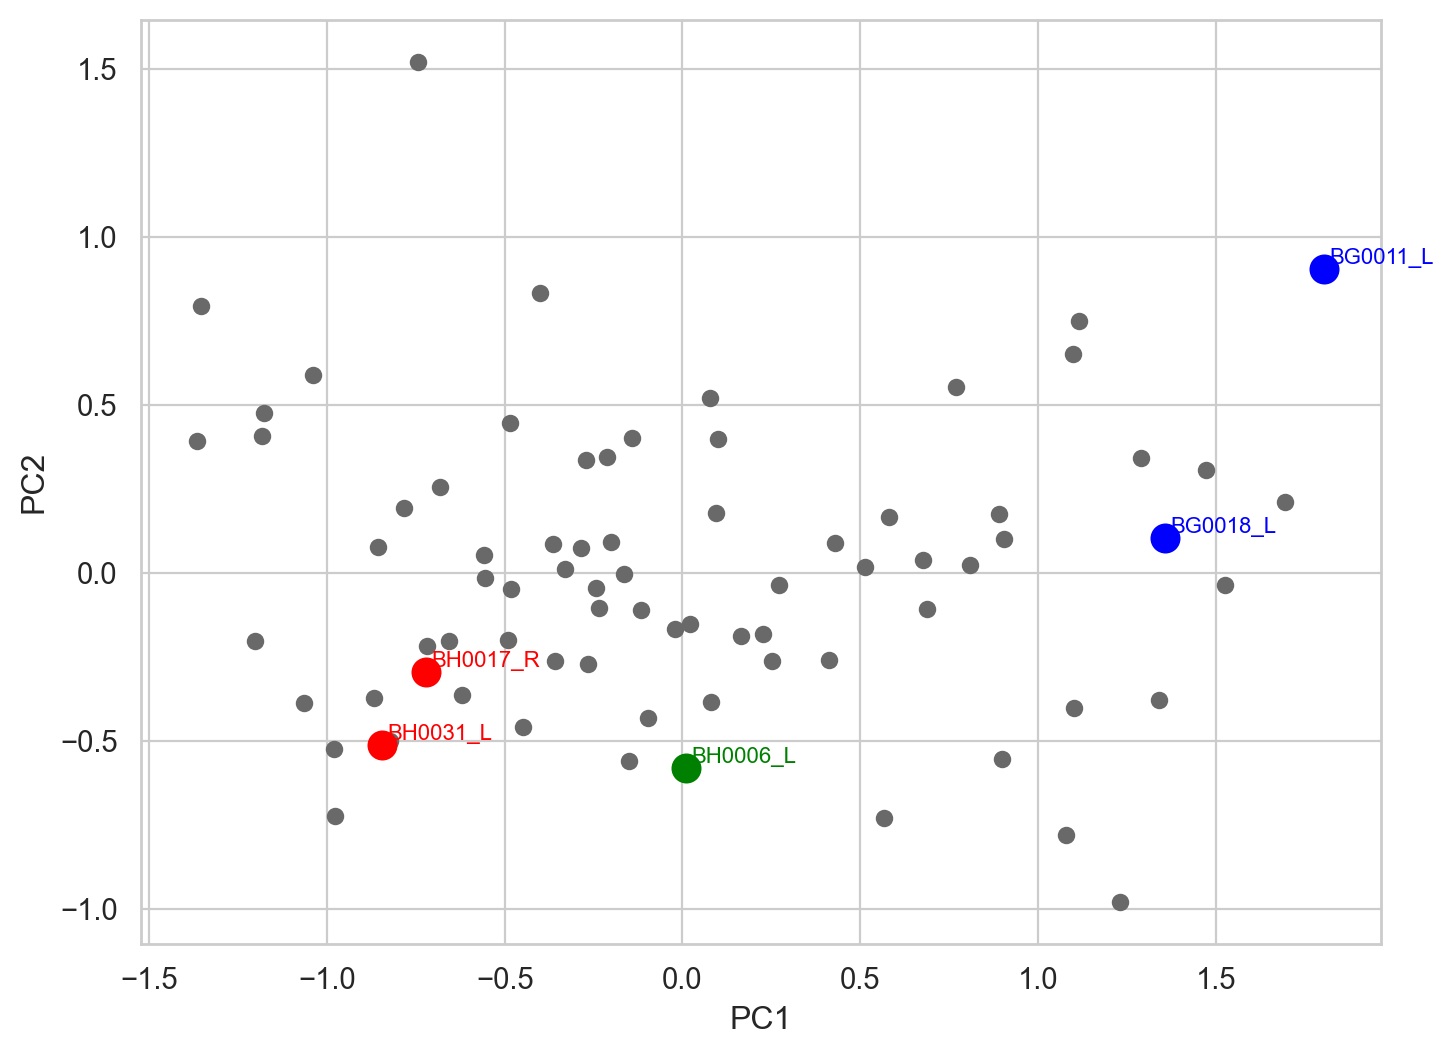

In [ ]:
fig = plt.figure(figsize=(8,6), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(df_pca['PC1'], df_pca['PC2'], c='dimgray', s=30, label='All samples')
for case_name in case_name_U:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='blue', s=100, label=f'Case U: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='blue')
for case_name in case_name_V:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='red', s=100, label=f'Case V: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='red')
for case_name in case_name_C:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='green', s=100, label=f'Case C: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='green')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()
